<a href="https://www.kaggle.com/code/giuliobenedetti/imagenet-reproducing-convnets?scriptVersionId=155528934" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

In this notebook, we aim to reproduce the model from [_Zimonyan & Zisserman 2015_](https://arxiv.org/pdf/1409.1556v6.pdf). In other words, we will design an analogous model on TensorFlow, train it with the data from the [ImageNet Object Classification Challenge](https://www.kaggle.com/competitions/imagenet-object-localization-challenge) and ultimately benchmark its performance with the original model.

In [1]:
# Import packages

# Data analysis
import numpy as np
import pandas as pd

# File management
import os
import shutil

# Image processing
import matplotlib.pyplot as plt
from skimage.io import imread
import skimage.transform as sktr

# Neural network
import tensorflow as tf
from tensorflow import keras
from keras import layers

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Here we list the constants that will be used for preprocessing and model design.

In [2]:
# Define constants

# Set number of classes to use (this is a way to subset the data)
CLASS_NUM = 3
# Set batch size for mini-batch gradient descent
BATCH_SIZE = 32
#BATCH_SIZE = 256

# Set kernel size for Conv2D layers
KERNEL_SIZE = 3
# Set padding mode for Conv2D layers
PAD_MODE = "same"
# Set activation function for Conv2D layers
ACTIVATION = "relu"

# Set pool size for MaxPool2D layers
POOL_SIZE = 2
# Set strides for MaxPool2D layers
POOL_STRIDES = 2

# Data Preprocessing

Because the train set is big (`train_dir`), we take a subset of classes defined by `CLASS_NUM` and copy the images belonging to that subset of classes to our working directory (`subset_dir`). Initially, we will train the model using only this subset.

In [3]:
# Store paths to base, train set and subset dirs
base_dir = "/kaggle/input/imagenet-object-localization-challenge/"
train_dir = base_dir + "ILSVRC/Data/CLS-LOC/train/"
subset_dir = "/kaggle/working/data/"

if not os.path.exists(subset_dir):
    os.mkdir(subset_dir)
    print(subset_dir, "created!")
else:
    print(subset_dir, "already exists!")
    
# Select only first n class dirs
class_dirs = os.listdir(train_dir)[:CLASS_NUM]

# Copy class dir from train set to working dir
for class_dir in class_dirs:
    # Define current source and destination paths
    source_dir = train_dir + class_dir
    destination_dir = subset_dir + class_dir
    
    # If new class, copy to working dir
    if not os.path.exists(destination_dir):
        shutil.copytree(source_dir, destination_dir)
        print(class_dir, "succesfully copied!")
    # If it exists, don't copy again
    else:
        print(class_dir, "doesn't need copying!")

/kaggle/working/data/ created!
n01531178 succesfully copied!
n02412080 succesfully copied!
n02098413 succesfully copied!


Now that the images were copied in our working directory, we try to open one as a sanity check. Which animal did you find?

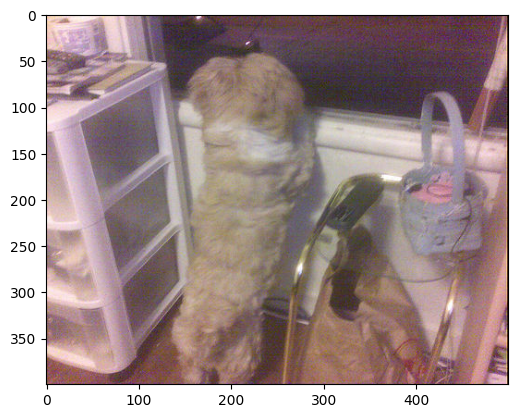

In [4]:
# Read in image
image = imread(subset_dir + "/n02098413/n02098413_720.JPEG")
# Show image
plt.imshow(image)

Then, we import our train set with keras utils. We are now ready to use it to train a model!

In [5]:
# Import train set as a Dataset object
# (this object type can be used as input to the model)
raw_train_set = keras.utils.image_dataset_from_directory(
    subset_dir,
    image_size=(224, 224),
    batch_size=BATCH_SIZE
)

# Normalise images to 0-centred distribution
train_set = raw_train_set.map(lambda x, y: (x - tf.reduce_mean(x), y))
# Separate images and labels
images, labels = next(iter(train_set))

Found 3900 files belonging to 3 classes.


In [6]:
# Prepare lists
files = []
labels = []

# Store file names and labels into lists
for class_dir in os.listdir(subset_dir):
    
    for file in os.listdir(subset_dir + class_dir):

        if file.endswith(".JPEG"):
            
            files.append(subset_dir + class_dir + "/" + file)
            labels.append(class_dir)

In [7]:
from multiprocessing import Pool

# Define function to preprocess images
def preprocess_image(file, S=256, start_height=0, start_width=0, crop_height=224, crop_width=224):
    
    # Read in the image
    image = imread(file)

    # Find smallest side, height or width
    min_side = min(image.shape[:2]) 
    scale = S / min_side
    
    # Rescale and crop image
    if len(image.shape) == 2:
        
        image = sktr.rescale(image, (scale, scale))
        image = image[start_height:start_height + crop_height, start_width:start_width + crop_width]
        
    elif len(image.shape) == 3:
        
        image = sktr.rescale(image, (scale, scale, 1))
        image = image[start_height:start_height + crop_height, start_width:start_width + crop_width, :]
            
    return image


# Preprocess images
with Pool(5) as p:
    images = p.map(preprocess_image, files)

In [8]:
# Select only rgb images and labels
rgb_images = [image for image in images if len(image.shape) == 3]
rgb_labels = [label for label, image in zip(labels, images) if len(image.shape) == 3]

# Prepare data for training
X_train = tf.constant(rgb_images)
y_train = pd.get_dummies(rgb_labels)

# Check input shape
input_shape = X_train.shape[1:]
print(f"Input shape: {input_shape}")

Input shape: (224, 224, 3)


# Model Design

In general, the model architecture resembles the model from the paper pretty well, even though some details may still be missing.

In [9]:
# Design model
model = keras.models.Sequential([
    
    # 1st convolutional block
    layers.Conv2D(input_shape=input_shape, filters=64, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
    layers.MaxPooling2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
    # 2nd convolutional block
    layers.Conv2D(filters=128, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
    layers.MaxPooling2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
    # 3rd convolutional block
    layers.Conv2D(filters=256, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
    layers.Conv2D(filters=256, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
    layers.MaxPool2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
    # 4th convolutional block
    layers.Conv2D(filters=512, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
    layers.Conv2D(filters=512, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
    layers.MaxPool2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
    # 5th convolutional block
    layers.Conv2D(filters=512, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
    layers.Conv2D(filters=512, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
    layers.MaxPool2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
    # Classifier head
    layers.Flatten(),
    layers.Dense(4096, activation=ACTIVATION),
    layers.Dropout(rate=0.5),
    layers.Dense(4096, activation=ACTIVATION),
    layers.Dropout(rate=0.5),
    layers.Dense(CLASS_NUM, activation="softmax")
])

In [10]:
# Define optimiser
sgd_optimiser = keras.optimizers.experimental.SGD(
    learning_rate=0.01,
    momentum=0.90,
    nesterov=False,
    weight_decay=0.0005
)

# Compile model
model.compile(
    optimizer = sgd_optimiser,
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"]
)

To test that the model works, we train it for a few epochs. Ideally, we will train the model on the full dataset when once it resembles the model from the paper in terms of parameter number. 

In [11]:
# Update learning rate
LR_Decay = keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.1,
    patience=2,
    mode="min",
    min_delta=1e-4,
    min_lr=1e-5
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=2,
    batch_size=BATCH_SIZE,
    verbose=True,
    callbacks=[LR_Decay]
)

# Store training history as a dataframe
history_df = pd.DataFrame(history.history)

print(f"Train loss: {history_df['loss'].iloc[-1]:.3f}")
print(f"Train accuracy: {history_df['categorical_accuracy'].iloc[-1]:.3f}")

Epoch 1/2
121/121 [==============================] - 29s 144ms/step - loss: 1.0676 - categorical_accuracy: 0.4206 - lr: 0.0100
Epoch 2/2
121/121 [==============================] - 15s 121ms/step - loss: 0.8108 - categorical_accuracy: 0.5864 - lr: 0.0100
Train loss: 0.811
Train accuracy: 0.586


The model contains 128778627 trainable parameters, which aligns pretty well with the 33 million in the paper. Our model may still lack some element responsible for the missing 4 million parameters.

<Axes: title={'center': 'Loss'}>

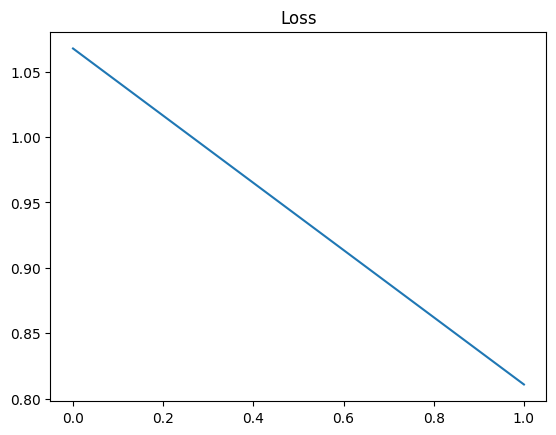

In [12]:
# Visualise loss
history_df.loc[:, "loss"].plot(title="Loss")

<Axes: title={'center': 'Accuracy'}>

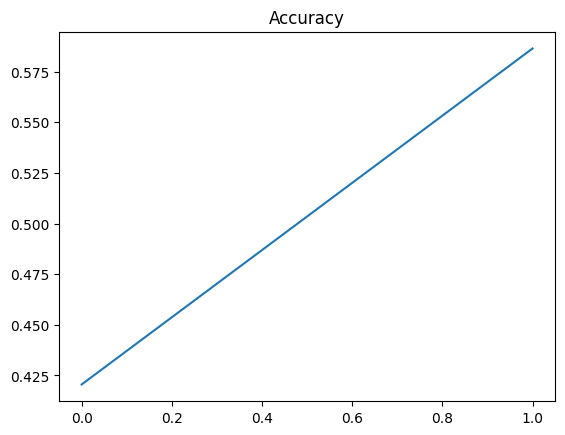

In [13]:
# Visualise accuracy
history_df.loc[:, "categorical_accuracy"].plot(title="Accuracy")

# Transfer Learning

The next step involves building a deeper ConvNet by:
1. taking the pretrained base from the previous section,
2. enriching it with new untrained convolutional layers and
3. attaching it to a new untrained classification head

By transferring the learnt weight from our previous model, we can build more complex and deeper ConvNets without too much computational burden. In particular, here we aim to reproduce the following four architectures from _Zimonyan & Zisserman 2015_:
- 13-layer ConvNet
- 16-layer ConvNet (with 1-by-1 filters)
- 16-layer ConvNet (with 3-by-3 filters)
- 19-layer ConvNet

In the following cell, we pretend that the previously trained model is stored in a keras file to show how pretrained models can be imported into a notebook.

In [14]:
# Define model file
model_file = f"/kaggle/working/{CLASS_NUM}class_model.keras"

# Save model into file for replication purposes
model.save(model_file)

# Import pretrained base
new_model = keras.models.load_model(model_file)

# IMPORTANT: Set weights from base as untrainable
new_model.trainable = False

Because we want to add new convolutional layers between the pretrained ones, we have to separate the latter from the whole pretrained base as done below.

In [15]:
# List indices of relevant layers (only convolutional, no maxpool)
layer_positions = [0, 2, 4, 5, 7, 8, 10, 11]

# Select relevant layers
pretrained_layers = [new_model.get_layer(index=i) for i in layer_positions]

## 13-layer ConvNet

Here, we build and train a 13-layer ConvNet with a half pretrained half untrained base.

In [16]:
# Design model
model = keras.models.Sequential([
    
    # 1st convolutional block
    pretrained_layers[0],
    layers.Conv2D(filters=64, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
    layers.MaxPooling2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
    # 2nd convolutional block
    pretrained_layers[1],
    layers.Conv2D(filters=128, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
    layers.MaxPooling2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
    # 3rd convolutional block
    pretrained_layers[2],
    pretrained_layers[3],
    layers.MaxPool2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
    # 4th convolutional block
    pretrained_layers[4],
    pretrained_layers[5],
    layers.MaxPool2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
    # 5th convolutional block
    pretrained_layers[6],
    pretrained_layers[7],
    layers.MaxPool2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
    # Classifier head
    layers.Flatten(),
    layers.Dense(4096, activation=ACTIVATION),
    layers.Dropout(rate=0.5),
    layers.Dense(4096, activation=ACTIVATION),
    layers.Dropout(rate=0.5),
    layers.Dense(CLASS_NUM, activation="softmax")
])

# Choose optimiser, loss function and validation metric
model.compile(
    optimizer=keras.optimizers.experimental.SGD(momentum=0.9, weight_decay=0.0005),
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"]
)

In [17]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=BATCH_SIZE,
    verbose=True
)

# Store training history as a dataframe
history_df = pd.DataFrame(history.history)

print(f"Train loss: {history_df['loss'].iloc[-1]:.3f}")
print(f"Train accuracy: {history_df['categorical_accuracy'].iloc[-1]:.3f}")

Epoch 1/5
121/121 [==============================] - 21s 152ms/step - loss: 0.9578 - categorical_accuracy: 0.4805
Epoch 2/5
121/121 [==============================] - 17s 140ms/step - loss: 0.6353 - categorical_accuracy: 0.6301
Epoch 3/5
121/121 [==============================] - 17s 140ms/step - loss: 0.6212 - categorical_accuracy: 0.6399
Epoch 4/5
121/121 [==============================] - 17s 140ms/step - loss: 0.6072 - categorical_accuracy: 0.6737
Epoch 5/5
121/121 [==============================] - 17s 141ms/step - loss: 0.5613 - categorical_accuracy: 0.7187
Train loss: 0.561
Train accuracy: 0.719


<Axes: title={'center': 'Loss'}>

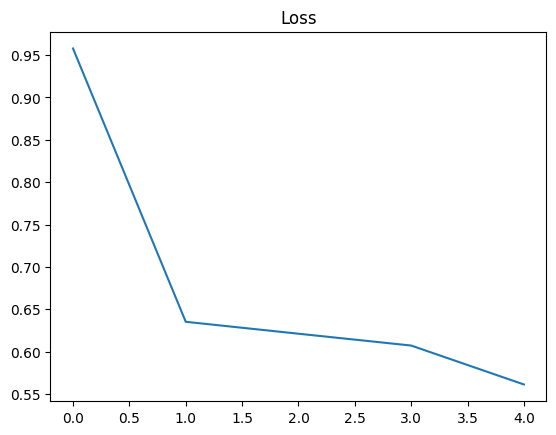

In [18]:
# Visualise loss
history_df.loc[:, "loss"].plot(title="Loss")

<Axes: title={'center': 'Accuracy'}>

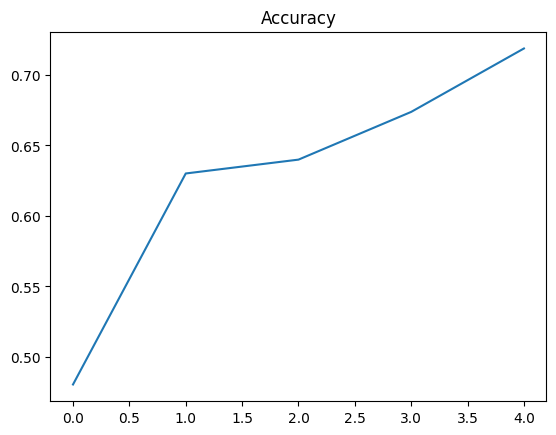

In [19]:
# Visualise accuracy
history_df.loc[:, "categorical_accuracy"].plot(title="Accuracy")